# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://github.com/Vaeliss/Pokemon_challenge/blob/main/pokemon.csv

Download the `pokemon.csv` file and put it in the file section of Colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

- **TAs achieved a F2-score of 0.80. Can you beat them?!**

# Imports and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

In [2]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [3]:
data = pd.read_csv('pokemon.csv')

In [4]:
data

,dexnum,name,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
0,1025,Pecharunt,9,Poison,Ghost,0.3,0.3,88,88,160,88,88,88,600,1
1,1024,Terapagos,9,Normal,NaN,0.2,6.5,90,65,85,65,85,60,450,1
2,1023,Iron Crown,9,Steel,Psychic,1.6,156.0,90,72,100,122,108,98,590,0
3,1022,Iron Boulder,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
4,1021,Raging Bolt,9,Electric,Dragon,5.2,480.0,125,73,91,137,89,75,590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5,Charmeleon,1,Fire,NaN,1.1,19.0,58,64,58,80,65,80,405,0
1021,4,Charmander,1,Fire,NaN,0.6,8.5,39,52,43,60,50,65,309,0
1022,3,Venusaur,1,Grass,Poison,2.0,100.0,80,82,83,100,100,80,525,0
1023,2,Ivysaur,1,Grass,Poison,1.0,13.0,60,62,63,80,80,60,405,0


In [5]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dexnum      1025 non-null   int64  
 1   name        1025 non-null   object 
 2   generation  1025 non-null   int64  
 3   type1       1025 non-null   object 
 4   type2       526 non-null    object 
 5   height      1025 non-null   float64
 6   weight      1025 non-null   float64
 7   hp          1025 non-null   int64  
 8   attack      1025 non-null   int64  
 9   defense     1025 non-null   int64  
 10  sp_atk      1025 non-null   int64  
 11  sp_def      1025 non-null   int64  
 12  speed       1025 non-null   int64  
 13  total       1025 non-null   int64  
 14  legendary   1025 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 120.2+ KB


In [7]:
data.isna().sum()

dexnum          0
name            0
generation      0
type1           0
type2         499
height          0
weight          0
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
total           0
legendary       0
dtype: int64

In [8]:
# Don't drop type2
data = data.drop(['dexnum', 'name'], axis=1)

# data = data.drop(['dexnum', 'name', 'type2'], axis=1)
# dropping type 2 is actually a debeatable step, it may provide useful information
# data = data.drop(["#", "Name"], axis=1)

In [9]:
data['legendary'] = data['legendary'].astype(int)
data['generation'] = data['generation'].astype(str)
data['type2'] = data['type2'].fillna('Undefined').astype(str)

In [10]:
data

,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
0,9,Poison,Ghost,0.3,0.3,88,88,160,88,88,88,600,1
1,9,Normal,Undefined,0.2,6.5,90,65,85,65,85,60,450,1
2,9,Steel,Psychic,1.6,156.0,90,72,100,122,108,98,590,0
3,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
4,9,Electric,Dragon,5.2,480.0,125,73,91,137,89,75,590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,Fire,Undefined,1.1,19.0,58,64,58,80,65,80,405,0
1021,1,Fire,Undefined,0.6,8.5,39,52,43,60,50,65,309,0
1022,1,Grass,Poison,2.0,100.0,80,82,83,100,100,80,525,0
1023,1,Grass,Poison,1.0,13.0,60,62,63,80,80,60,405,0


Categorical variables are one-hot encoded

In [11]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [12]:
data = onehot_encode(data, 'type1', 't')
data = onehot_encode(data, 'generation', 'g')
data = onehot_encode(data, 'type2', 't2')

In [13]:
data.shape

(1025, 56)

## Splitting and Scaling

In [14]:
data.columns # note that only the first 9 features are continuous now

Index(['height', 'weight', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def',
       'speed', 'total', 'legendary', 't_Bug', 't_Dark', 't_Dragon',
       't_Electric', 't_Fairy', 't_Fighting', 't_Fire', 't_Flying', 't_Ghost',
       't_Grass', 't_Ground', 't_Ice', 't_Normal', 't_Poison', 't_Psychic',
       't_Rock', 't_Steel', 't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5',
       'g_6', 'g_7', 'g_8', 'g_9', 't2_Bug', 't2_Dark', 't2_Dragon',
       't2_Electric', 't2_Fairy', 't2_Fighting', 't2_Fire', 't2_Flying',
       't2_Ghost', 't2_Grass', 't2_Ground', 't2_Ice', 't2_Normal', 't2_Poison',
       't2_Psychic', 't2_Rock', 't2_Steel', 't2_Undefined', 't2_Water'],
      dtype='object')

In [15]:
y = data['legendary']
X = data.drop('legendary', axis=1)

In [16]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:9])
X = np.concatenate((X_scaled, np.array(X.iloc[:,9:])), axis=1)

In [17]:
# keep the proportions for the split equal and specify a seed of 42, we want a fair fight!
# Note: end split should be 0.60,0.20,0.20 for train,valid,test

train_size = 0.6
valid_size = 0.4
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_size, random_state=42)

X_train.shape, X_valid.shape, X_test.shape

((615, 55), (205, 55), (205, 55))

# Model definition

In [18]:
device = 'cuda'
print(f"Using {device} device")

Using cuda device


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input and output, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [19]:
from torch.nn import functional as F

class Modelicious(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn = nn.BatchNorm1d(55)
        self.stack = nn.Sequential(
            nn.Linear(55, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.1),
        )
        self.clf_head = nn.Linear(512, 1)
        
    def forward(self, x, y: torch.Tensor = None):
        x_inp = x
        
        if y is not None:
            # if it's class one, it gets a random fuzz
            mask = y == 1
            x_inp = x_inp + torch.randn_like(x_inp) * (0.1) * mask
            
        x = self.stack(self.bn(x))

        y_hat_logits = self.clf_head(x)

        loss = None
        if y is not None:
            weights = y * 10 + 1 # class 1 gets more importance 10:1
            loss = F.binary_cross_entropy_with_logits(input=y_hat_logits, target=y, weight=weights)
        return y_hat_logits, loss

Instantiate your model and print it out

In [20]:
model = Modelicious()
model

Modelicious(
  (bn): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stack): Sequential(
    (0): Linear(in_features=55, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): GELU(approximate='none')
    (6): Dropout(p=0.1, inplace=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): GELU(approximate='none')
    (10): Dropout(p=0.1, inplace=False)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): GELU(approximate='none')
    (14): Dropout(p=0.1, inplace=False)
    (15): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=Tru

### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs.
- other hyperparameters that you might need

In [21]:
LR = 1e-4
BS = len(X_train) # Everything. This task is imbalanced, larger batch == better
EPOCHS = 175 * 5

### Loss function and optimizer:

- What's the appropriate loss function for the task?
- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [22]:
# Model defines one
# AdamW is good enough
opt = optim.AdamW(model.parameters(), lr=LR,)

Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.

In [23]:
from torch.utils.data import DataLoader, TensorDataset

class NumpyTensorDataset(TensorDataset):
    def __init__(self, x, y):
        # DF -> np -> torch -> TensorDS
        x = torch.tensor(np.array(x)).float() # No need for double
        y = torch.tensor(np.array(y)).float().unsqueeze(-1) # It's binary, so int is OK
        super().__init__(x, y)

train_ds = NumpyTensorDataset(X_train, y_train)
valid_ds = NumpyTensorDataset(X_valid, y_valid)
test_ds = NumpyTensorDataset(X_test, y_test)

trainloader = DataLoader(train_ds, batch_size=BS)
validloader = DataLoader(valid_ds, batch_size=BS * 2) # 2x Not needed, but it's a muscle memory at this point...
testloader = DataLoader(test_ds, batch_size=BS * 2)

In [24]:
# Keep track of training and validation losses during training

train_loss_list = []
valid_loss_list = []

train_length = len(trainloader)
valid_length = len(validloader)

# Training

Implement your training and evaluation (for the validation set) loops

In [25]:
model = model.to(device)

for epoch in range(EPOCHS):
    for batch in trainloader:
        opt.zero_grad()
        xbs, ybs = batch
        xbs, ybs = xbs.to(device), ybs.to(device)
        y_hat_logits, loss = model(xbs, ybs)
        loss.backward()
        opt.step()
    # print(f"{epoch}:TRAIN:{loss.item():.5f}", end='\r') # there's only 1 batch, so this is OK
    train_loss_list.append(loss.item())

    with torch.no_grad():
        for batch in validloader:
            xbs, ybs = batch
            xbs, ybs = xbs.to(device), ybs.to(device)
            y_hat_logits, loss = model(xbs, ybs)
    print(f"{epoch}:VALID:{loss.item():.5f}") # there's only 1 batch, so this is OK
    valid_loss_list.append(loss.item())

0:VALID:1.20345
1:VALID:1.15241
2:VALID:1.08463
3:VALID:1.06966
4:VALID:0.99334
5:VALID:0.98866
6:VALID:0.93490
7:VALID:0.92146
8:VALID:0.91032
9:VALID:0.87860
10:VALID:0.85227
11:VALID:0.84225
12:VALID:0.83328
13:VALID:0.81758
14:VALID:0.80311
15:VALID:0.83236
16:VALID:0.81004
17:VALID:0.81589
18:VALID:0.78223
19:VALID:0.78742
20:VALID:0.75923
21:VALID:0.79065
22:VALID:0.78452
23:VALID:0.78762
24:VALID:0.78473
25:VALID:0.76149
26:VALID:0.75043
27:VALID:0.74757
28:VALID:0.78190
29:VALID:0.80349
30:VALID:0.76274
31:VALID:0.72857
32:VALID:0.72095
33:VALID:0.70709
34:VALID:0.65983
35:VALID:0.71136
36:VALID:0.69104
37:VALID:0.70540
38:VALID:0.71453
39:VALID:0.72546
40:VALID:0.64749
41:VALID:0.67876
42:VALID:0.73107
43:VALID:0.65127
44:VALID:0.70256
45:VALID:0.63496
46:VALID:0.66540
47:VALID:0.64559
48:VALID:0.62430
49:VALID:0.65048
50:VALID:0.67135
51:VALID:0.63493
52:VALID:0.62756
53:VALID:0.57934
54:VALID:0.55635
55:VALID:0.56501
56:VALID:0.65662
57:VALID:0.61568
58:VALID:0.59686
59:VALI

# Results

### Plotting

Plot out the training and validation losses over the epochs

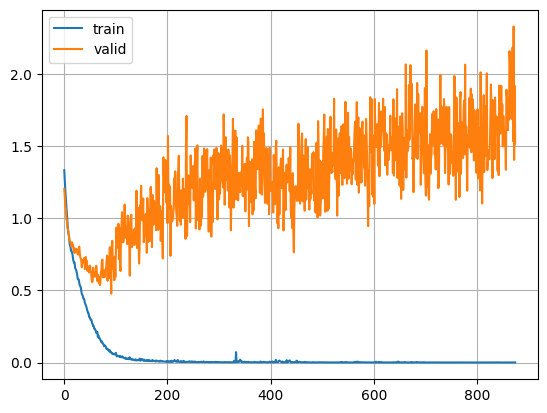

In [26]:
plt.plot( train_loss_list , label='train') # TODO
plt.plot( valid_loss_list , label='valid') # TODO
plt.legend(loc="best")
plt.grid("on")
plt.show()

### Metrics

Print out appropriate metrics for the task

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       185
           1       0.74      0.85      0.79        20

    accuracy                           0.96       205
   macro avg       0.86      0.91      0.88       205
weighted avg       0.96      0.96      0.96       205

fbeta@2 = 0.8252427184466019


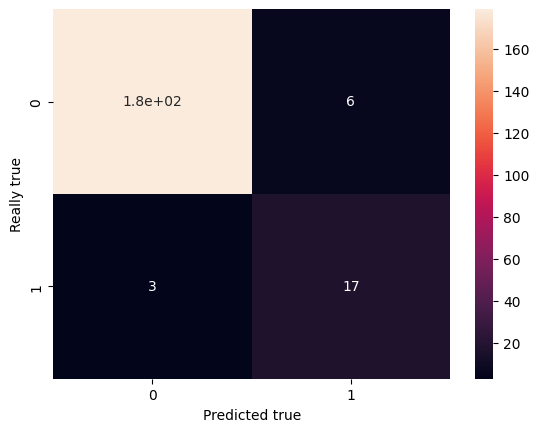

In [27]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

with torch.no_grad():
    x = next(iter(testloader))[0]
    y_hat_logits, _ = model(x.to(device))
    y_hat = (y_hat_logits.cpu().sigmoid() > .5).int().numpy()
    print(classification_report(
        y_test.values, y_hat
    ))
    print(f"fbeta@2 = {fbeta_score(y_test, y_hat, beta=2)}")
    sns.heatmap(confusion_matrix(y_test.values, y_hat, ), annot=True)
    plt.xlabel('Predicted true')
    plt.ylabel('Really true')

In [28]:
wrong_predictions = None

  Did you manage to catch them all?

______________________________________________________________________________

This notebook is largely inspired (with some improvements and updates) by a video featured on [Data Every Day](https://www.youtube.com/watch?v=3Fr1npNxkJk).